# Mini-projeto Não Supervisionado

K-means é um algoritmo de aprendizado de máquina não supervisionado para a clusterização de dados. A ideia principal do K-means é agrupar dados que possuam características semelhantes em clusters distintos, sem ter informações prévias sobre esses grupos. Ele utiliza a distância euclidiana para calcular a semelhança entre os pontos e, em seguida, agrupá-los em clusters. O algoritmo funciona iterativamente, onde inicialmente um número k de centróides é escolhido aleatoriamente. Em seguida, os pontos mais próximos de cada centróide são atribuídos a esse cluster. Depois disso, os centróides são recalculados como a média dos pontos dentro de cada cluster, e o processo é repetido até que a convergência seja alcançada.

K-medoids é um algoritmo de clusterização não supervisionado que é semelhante ao K-means, mas ao invés de usar centróides como representantes dos clusters, ele usa pontos reais dos dados, chamados de medóides. Um medóide é um ponto do cluster que minimiza a soma das distâncias entre ele e todos os outros pontos do cluster. O algoritmo K-medoids é mais robusto do que o K-means para dados com ruído, pois a escolha dos medóides é menos sensível a outliers. Além disso, ele também pode ser mais robusto em relação à inicialização dos centróides, uma vez que a escolha dos medóides é menos influenciada por valores extremos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
import sklearn.metrics as sklearn_metrics
from scipy.spatial import distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00


## Dataset

O conjunto de dados "US News and World Reports College Data" é um conjunto de dados de avaliações de faculdades e universidades nos Estados Unidos, disponibilizado no Kaggle, onde temos um conjunto de dados com informações de 777 instituições de ensino superior, incluindo características como tamanho do corpo estudantil, taxa de aceitação, despesas com educação, porcentagem de alunos que se formam em quatro anos, entre outras e também inclui informações sobre a classificação de cada instituição em diversas categorias, como "Melhores Faculdades de Artes Liberais" e "Melhores Faculdades Regionais do Norte". Vamos visualizar o Dataset para saber que tipos de dados estamos tratando:

In [2]:
# Getting the data
csv_path = 'College.csv'
data = pd.read_csv(csv_path)
data.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [3]:
# Checking how many information we are dealing with and how it is distributed
data.shape

(777, 19)

O que é apresentado em cada coluna:

*    Apps → Número de inscrições recebidas
*    Accept → Número de inscrições aceitas
*    Enroll → Número de novos alunos matriculados
*    Top10perc → Porcentagem de novos alunos do top 10% da turma do ensino médio
*    Top25perc → Porcentagem de novos alunos do top 25% da turma do ensino médio
*    F.Undergrad → Número de alunos de graduação em tempo integral
*    P.Undergrad → Número de alunos de graduação em tempo parcial
*    Outstate → Mensalidade para estudantes fora do estado
*    Room.Board → Custos de alojamento e alimentação
*    Books → Custos estimados de livros
*    Personal → Gastos pessoais estimados
*    PhD → Porcentagem do corpo docente com doutorado
*    Terminal → Porcentagem do corpo docente com grau terminal
*    S.F.Ratio → Relação aluno/faculdade
*    perc.alumni → Porcentagem de ex-alunos que doam
*    Expend Instructional → Despesas por aluno
*    Grad.Rate → Taxa de graduação

## Removendo Colunas e Dados Nulos
Removeremos a coluna “unnamed” que contém o nome de cada universidade, pois não virá a ser útil em nossa análise. Logo após isso, removeremos a coluna "Private" para que possamos tratar o problema de forma não-supervisionada. Checaremos as entradas nulas, dadas por ‘NaN’ e as removemos caso existam. Neste caso, não há nenhum aparecimento, não sendo então necessário remoção.

In [4]:
# Dropping the 'Unnamed' column, with the names of each university
data_att = data.drop(['Unnamed: 0'], axis=1)
data_att.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [5]:
# Remove Private column, but keeping a copy for future evaluation
data_att_private = data_att
data_att = data_att.drop('Private', axis=1)

In [6]:
# Checking of NaN entries
data_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Apps         777 non-null    int64  
 1   Accept       777 non-null    int64  
 2   Enroll       777 non-null    int64  
 3   Top10perc    777 non-null    int64  
 4   Top25perc    777 non-null    int64  
 5   F.Undergrad  777 non-null    int64  
 6   P.Undergrad  777 non-null    int64  
 7   Outstate     777 non-null    int64  
 8   Room.Board   777 non-null    int64  
 9   Books        777 non-null    int64  
 10  Personal     777 non-null    int64  
 11  PhD          777 non-null    int64  
 12  Terminal     777 non-null    int64  
 13  S.F.Ratio    777 non-null    float64
 14  perc.alumni  777 non-null    int64  
 15  Expend       777 non-null    int64  
 16  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16)
memory usage: 103.3 KB


## Buscando Valores Impossíveis
Agora, percorreremos o dataset em busca de valores atípicos que podem poluir nosso dataset, como taxas de graduação acima de 100% ou abaixo de 0%, por exemplo.

In [7]:
# Taking a look at the general distributions of the dataset, finding outliers
data_att.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000



Removeremos esses valores para obter um resultado mais consistente para o algoritmo:

In [8]:
# Removing rates over 100%
data_att = data_att.drop(data_att[data_att['PhD'] > 100].index)
data_att = data_att.drop(data_att[data_att['Grad.Rate'] > 100].index)
data_att_private = data_att_private.drop(data_att_private[data_att_private['PhD'] > 100].index)
data_att_private = data_att_private.drop(data_att_private[data_att_private['Grad.Rate'] > 100].index)
data_att.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000
mean,3003.738065,2018.963871,780.992258,27.589677,55.834839,3706.596129,857.317419,10449.233548,4358.498065,549.250323,1342.618065,72.686452,79.734194,14.085161,22.756129,9666.891613,65.424516
std,3874.059459,2453.129603,930.130671,17.649382,19.813695,4854.888544,1523.874315,4023.024844,1097.076543,165.298459,676.813950,16.210853,14.691366,3.961664,12.405035,5226.728607,17.076789
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.000000
25%,778.000000,605.500000,242.000000,15.000000,41.000000,990.000000,95.000000,7332.000000,3597.500000,469.000000,870.000000,62.000000,71.000000,11.500000,13.000000,6754.000000,53.000000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1708.000000,355.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8408.000000,65.000000
75%,3610.000000,2413.000000,902.500000,35.000000,69.000000,4055.500000,967.500000,12937.500000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10847.000000,78.000000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,100.000000,100.000000,39.800000,64.000000,56233.000000,100.000000


Logo após remover esses valores, checaremos novamente os dados:

In [9]:
# Rechecking our dataset
data_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 776
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Apps         775 non-null    int64  
 1   Accept       775 non-null    int64  
 2   Enroll       775 non-null    int64  
 3   Top10perc    775 non-null    int64  
 4   Top25perc    775 non-null    int64  
 5   F.Undergrad  775 non-null    int64  
 6   P.Undergrad  775 non-null    int64  
 7   Outstate     775 non-null    int64  
 8   Room.Board   775 non-null    int64  
 9   Books        775 non-null    int64  
 10  Personal     775 non-null    int64  
 11  PhD          775 non-null    int64  
 12  Terminal     775 non-null    int64  
 13  S.F.Ratio    775 non-null    float64
 14  perc.alumni  775 non-null    int64  
 15  Expend       775 non-null    int64  
 16  Grad.Rate    775 non-null    int64  
dtypes: float64(1), int64(16)
memory usage: 109.0 KB


# Analisando Características de Universidades Privadas e Públicas

Vamos observar como os diferentes atributos se comportam de acordo com universidades privadas e públicas. Futuramente isso será útil para determinar quais clusters melhor representam cada classificação e assim, poder observar o funcionamento do mesmo. 

Dentre as métricas que se destacam, estão o "Apps", "F.Undergrad" e "P.Undergrad", mostrando que ambas as universidades possuem distribuições similares de alunos em tempo integral e turno, porém mostrando grande disparidade no tamanho das universidades, com universidades públicas sendo consideravelmente maiores que universidades privadas. Além disso, valores relacionados com custos dos alunos como "Personal" e "Expend" também são maiores quando falamos de universidades públicas.

In [10]:
data_att_private_yes = data_att_private[data_att_private['Private'] == 'Yes']
data_att_private_no = data_att_private[data_att_private['Private'] == 'No']

## Privada

In [11]:
data_att_private_yes.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,1974.615248,1301.930851,456.820922,29.367021,56.996454,1873.696809,434.714539,11805.980496,4585.693262,547.413121,1215.707447,71.180851,78.590426,12.943085,25.900709,10491.299645,68.911348
std,2444.239052,1367.824944,457.925752,17.846644,19.583859,2112.222348,722.792607,3709.360272,1090.612318,175.073589,632.724154,17.242372,15.406648,3.521233,12.409276,5686.403864,16.636409
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,2370.000000,250.000000,250.000000,8.000000,24.000000,2.500000,2.000000,3186.000000,15.000000
25%,618.250000,501.000000,205.500000,17.000000,42.750000,840.000000,63.000000,9100.000000,3735.750000,450.000000,800.000000,60.000000,68.000000,11.100000,16.000000,7468.750000,58.000000
50%,1132.500000,859.000000,328.000000,25.000000,55.000000,1276.500000,207.500000,11204.000000,4400.000000,500.000000,1100.000000,73.000000,81.000000,12.700000,25.000000,8957.000000,69.000000
75%,2177.000000,1579.250000,515.500000,36.250000,70.000000,2019.000000,541.000000,13994.250000,5400.000000,600.000000,1500.000000,85.000000,92.000000,14.500000,34.000000,11629.000000,81.000000
max,20192.000000,13007.000000,4615.000000,96.000000,100.000000,27378.000000,10221.000000,21700.000000,8124.000000,2340.000000,6800.000000,100.000000,100.000000,39.800000,64.000000,56233.000000,100.000000


## Pública

In [12]:
data_att_private_no.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,5754.568720,3935.582938,1647.497630,22.838863,52.729858,8605.909953,1986.928910,6822.668246,3751.208531,554.161137,1681.848341,76.710900,82.791469,17.137915,14.350711,7463.260664,56.104265
std,5371.414036,3477.412482,1260.890329,16.218819,20.134973,6463.030464,2323.054725,2146.100817,859.089321,136.016115,675.401514,12.213452,12.093057,3.426130,7.535961,2700.988037,14.590229
min,233.000000,233.000000,153.000000,1.000000,12.000000,633.000000,9.000000,2580.000000,1780.000000,96.000000,400.000000,33.000000,33.000000,6.700000,0.000000,3605.000000,10.000000
25%,2211.000000,1601.000000,707.000000,12.000000,37.000000,3645.500000,610.500000,5383.500000,3128.000000,500.000000,1200.000000,71.000000,76.000000,15.100000,9.000000,5714.000000,46.000000
50%,4345.000000,2959.000000,1372.000000,19.000000,51.000000,6851.000000,1387.000000,6618.000000,3710.000000,550.000000,1651.000000,78.000000,86.000000,17.200000,13.000000,6717.000000,55.000000
75%,7752.000000,5271.000000,2254.500000,28.000000,65.000000,12536.000000,2513.500000,7844.000000,4364.000000,612.000000,2052.500000,86.000000,92.000000,19.350000,19.000000,8581.500000,65.000000
max,48094.000000,26330.000000,6392.000000,95.000000,100.000000,31643.000000,21836.000000,15732.000000,6540.000000,1125.000000,4288.000000,99.000000,100.000000,28.800000,48.000000,16527.000000,100.000000


## Matriz De Correlação

Após o tratamento inicial dos dados, iremos fazer uma matriz de correlação para averiguar as correlações entre os atributos.



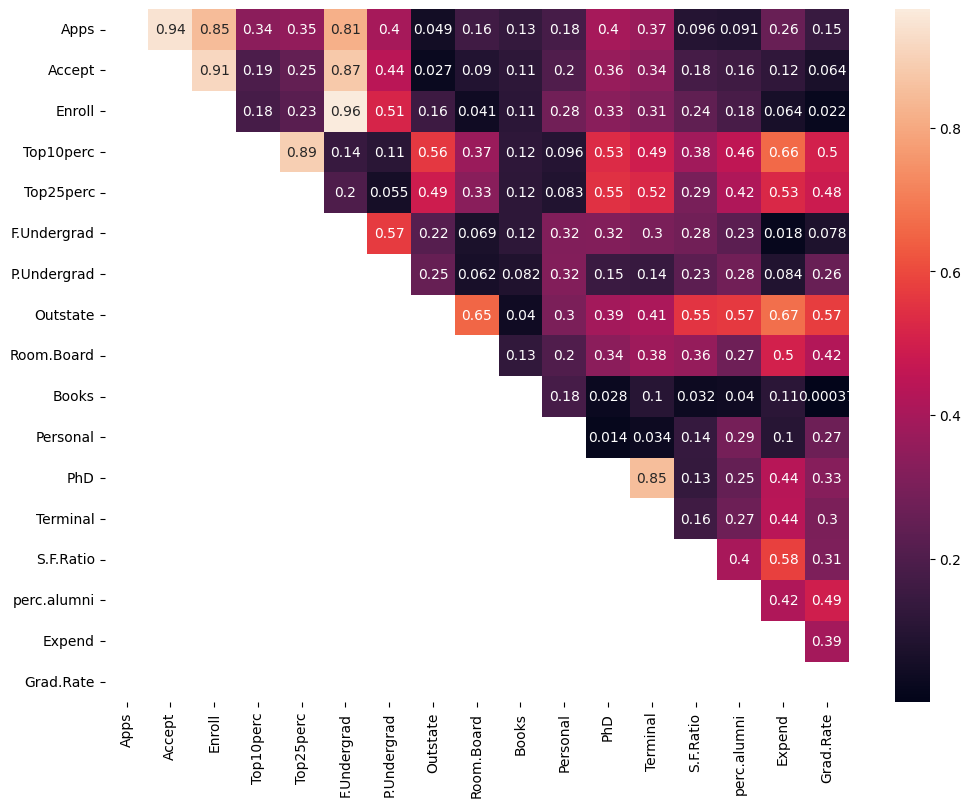

In [13]:
# Correlation matrix to check for unusable values
corr_matrix = data_att.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure(figsize=(12,9))
sns.heatmap(upper_tri, annot=True)
plt.show()

Pelo fato desse dataset ter um número alto de atributos, removeremos algumas das colunas que tem alta correlação entre si para evitar colinearidade. Feito isso, teremos menos atributos que por sua vez serão mais importantes para o resultado final. Os atributos selecionados foram "Apps", "Accept", "Enroll", "Terminal", "Top10perc", "Top25perc", que além de apresentarem alto grau de correlação com outros atributos, nós entendemos que eles não são necessariamente importantes para o resultado final de um ponto de vista lógico.

In [14]:
# Remove variables with high multicolinearity
data_att = data_att.drop(["Apps", "Accept", "Enroll", "Terminal", "Top10perc", "Top25perc"], axis=1)
data_att_private = data_att_private.drop(["Apps", "Accept", "Enroll", "Terminal", "Top10perc", "Top25perc"], axis=1)

## Mapeando Atributos de Custo


Para os atributos que representam custos do estudante, isto é, atributos que precisam ser avaliados no que se refere à variação dos valores, utilizaremos um gráfico box-plot para separá-los em quartis. Realizando esse processo, descobriremos outliers, que aparecem após a avaliação dos valores e se mostram bastante destoantes do restante e portanto, iremos removê-los também:

In [15]:
# Mapping cost Columns
def attr_info(attr):
    bp = plt.boxplot(data_att[attr], showmeans=True)

    minimum = [item.get_ydata()[0] for item in bp["caps"]][::2]
    q1 = [min(item.get_ydata()) for item in bp["boxes"]]
    q3 = [max(item.get_ydata()) for item in bp["boxes"]]
    maximum = [item.get_ydata()[0] for item in bp["caps"]][1::2]
    return minimum[0], q1[0], q3[0], maximum[0]

def map_cost(value, info):
    if value < info[0]:
        return 0
    elif info[0] <= value < info[1]:
        return 1
    elif info[1] <= value < info[2]:
        return 2
    elif info[2] <= value < info[3]:
        return 3
    else:
        return 4

attrs = ["Expend", "Books", "Outstate", "Personal", "Room.Board"]

# for attr in attrs:
#     info = attr_info(attr)
#     data_att[attr] = data_att[attr].map(lambda v: map_cost(v, info))
#     data_att_private[attr] = data_att_private[attr].map(lambda v: map_cost(v, info))

#     data_att = data_att[data_att[attr] < 4]
#     data_att = data_att[data_att[attr] > 0]
#     data_att_private = data_att_private[data_att_private[attr] < 4]
#     data_att_private = data_att_private[data_att_private[attr] > 0]


data_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 776
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   F.Undergrad  775 non-null    int64  
 1   P.Undergrad  775 non-null    int64  
 2   Outstate     775 non-null    int64  
 3   Room.Board   775 non-null    int64  
 4   Books        775 non-null    int64  
 5   Personal     775 non-null    int64  
 6   PhD          775 non-null    int64  
 7   S.F.Ratio    775 non-null    float64
 8   perc.alumni  775 non-null    int64  
 9   Expend       775 non-null    int64  
 10  Grad.Rate    775 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 72.7 KB


## Visualizando a Distribuição dos Dados

Após todos os processos de tratamento e normalização dos dados, temos o dataset final a ser utilizado pelo algoritmo. Agora, iremos visualizar brevemente a nova distribuição dos dados de custo que foram mapeados:

In [16]:
def plot_bar(attr):
    labels = data_att[attr].unique()
    labels.sort()
    values = data_att[attr].value_counts().sort_index()

    plt.bar(labels, values)
    plt.title(attr)
    plt.xlabel("Groups")
    plt.ylabel("Amount")
    plt.show()

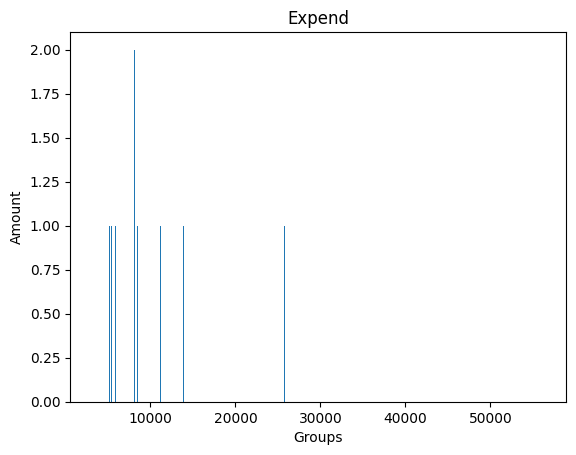

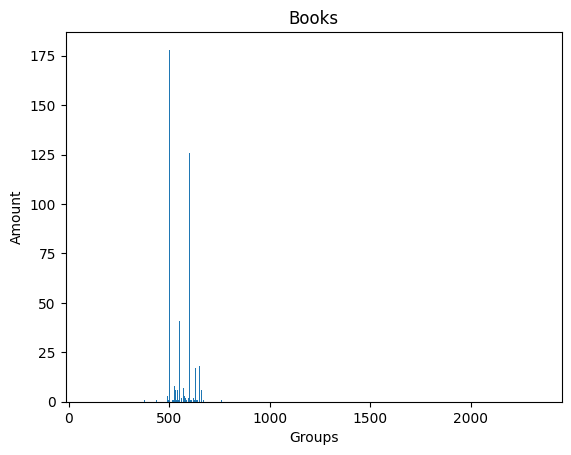

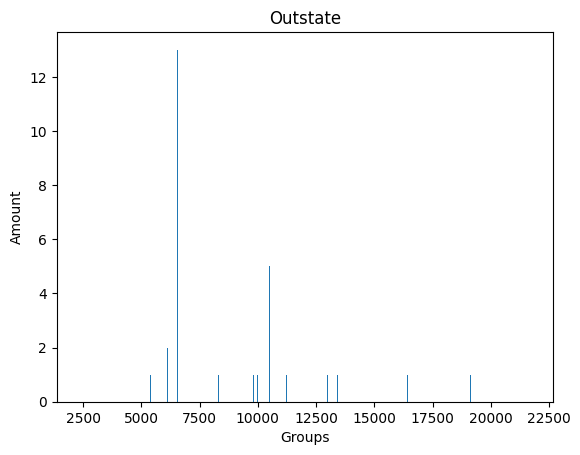

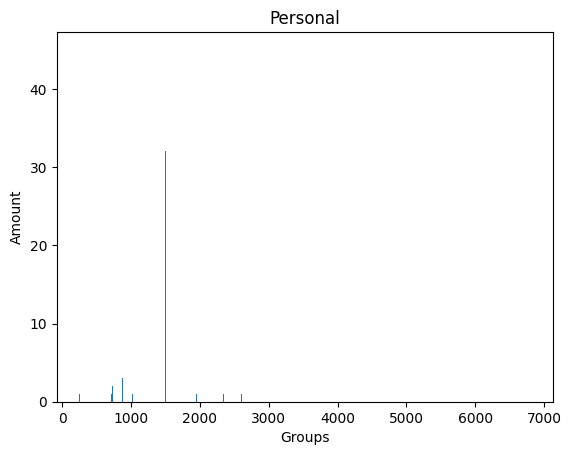

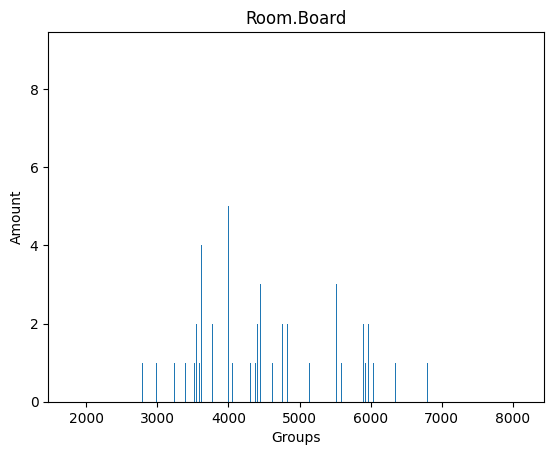

In [17]:
for attr in attrs:
    plot_bar(attr)

## Normalizando os dados

Normalizamos os dados do Dataset, visto que esses algoritmos de clusterização dependem fortemente da distância entre os pontos de dadods para determinar os clusters e, por consequência, são extremamente sensíveis a dados com valores extremamente distintos. Ter as características dos dados com escalas muito diferentes acaba fazendo com que a distância calculada possa ser dominada pelas características com maiores valores absolutos.

Ao normalizar os dados, as características são transformadas em escala comum, como pode ser visto abaixo, garantindo que cada um contribua igualmente para a distância entre os pontos dados:

In [18]:
# Normalizing the data
data_att_no_norm = data_att
scaled_data_att = pd.DataFrame(normalize(data_att, axis=0), columns=data_att.columns)
data_att = scaled_data_att
data_att.head()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,0.016973,0.011038,0.023870,0.026376,0.028183,0.052566,0.033765,0.044438,0.016634,0.023018,0.031876
1,0.015785,0.025220,0.039399,0.051552,0.046972,0.035841,0.013988,0.029953,0.022179,0.034415,0.029751
2,0.006095,0.002035,0.036094,0.029972,0.025052,0.027836,0.025565,0.031671,0.041585,0.028556,0.028689
3,0.003000,0.001295,0.041581,0.043560,0.028183,0.020907,0.044377,0.018905,0.051288,0.062167,0.031345
4,0.001465,0.017862,0.024255,0.032930,0.050103,0.035841,0.036659,0.029216,0.002772,0.035706,0.007969


## Criando uma Cópia do Dataset

Criaremos uma cópia do nosso dataset tratado e normalizado para que haja uma cópia para utilizarmos no algoritmo K-means e outra para o K-medoids:

In [19]:
# Creating separate copies for each method we will be using
data_att_means = data_att
data_att_medoids = data_att

## Métricas para descobrir o melhor valor de K

Para descobrir qual é o melhor valor de K, faremos um cálculo de métricas para avaliar a qualidade do modelo. A função bic_score vai calcular o valor da métrica Bayesian Information Criterion (BIC) para o modelo e vai avaliar a qualidade do modelo considerando a capacidade de ajuste do modelo e seu número  de parâmetros. Quanto menor o valor do BIC, melhor é o modelo.

Além do BIC, outras métricas de avaliação são feitas, como o "Elbow Method", o índice de Calinski-Harabasz, o índice de Davies-Bouldin e o coeficiente de silhueta. Para isso, o código assume uma lista de K e testa o desempenho do K-Médias em cada métrica para que seja possível definir qual o melhor K. Observando os gráficos resultantes, é feita a escolha de K=2, sendo aquele que em mais métricas foi responsável por obter o melhor desempenho. 

In [20]:
def bic_score(kmeans, X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels = kmeans.labels_
    # number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    # size of data set
    N, d = X.shape

    # compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]],
                                                           'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
                  n[i] * np.log(N) -
                  ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
                  ((n[i] - 1) * d / 2) for i in range(m)]) - const_term

    return (BIC)


In [21]:
# Calculate scores using various methods
scores = {"elbow": [], "calinski-harabasz": [], "davies-bouldin": [], "silhouette": [], "bic": []}

k_range = [i for i in range(2, 9)]

kmeans = KMeans(n_clusters=1, n_init=10).fit(data_att_means)
scores["elbow"].append(kmeans.inertia_)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(data_att_means)
    labels = kmeans.labels_
    scores["elbow"].append(kmeans.inertia_) # Elbow is better
    scores["calinski-harabasz"].append(sklearn_metrics.calinski_harabasz_score(data_att_means, labels)) # Higher is better
    scores["davies-bouldin"].append(sklearn_metrics.davies_bouldin_score(data_att_means, labels)) # Lower is better
    scores["silhouette"].append(sklearn_metrics.silhouette_score(data_att_means, labels)) # Higher is better
    scores["bic"].append(bic_score(kmeans, data_att_means)) # Lower is better

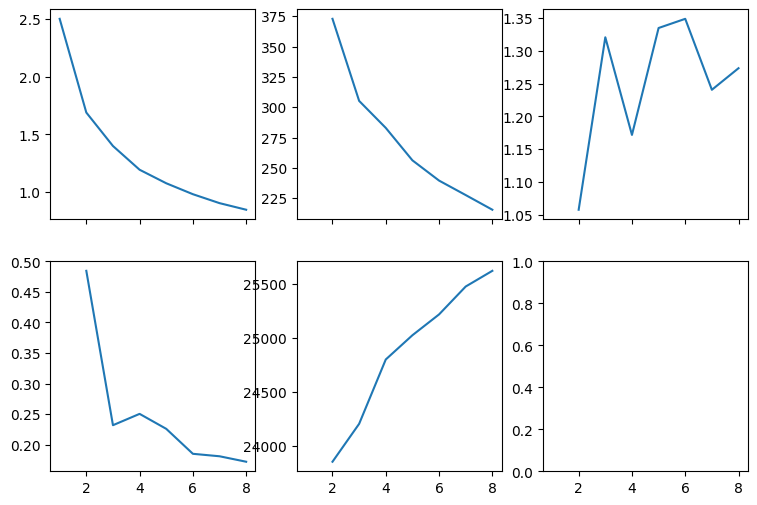

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=False)

ax[0, 0].plot([1] + k_range, scores["elbow"], label="elbow")
ax[0, 1].plot(k_range, scores["calinski-harabasz"], label="calinski-harabasz")
ax[0, 2].plot(k_range, scores["davies-bouldin"], label="davies-bouldin")
ax[1, 0].plot(k_range, scores["silhouette"], label="silhouette")
ax[1, 1].plot(k_range, scores["bic"], label="bic")

plt.show()

## Treinando os Modelos utilizando o K-means e o K-medoids

Agora, entraremos na fase de treinamento dos modelos, para isso, é necessário escolher a quantidade de clusters a ser utilizado em cada um dos modelos. O número de clusters selecionado para ambos foi 2, porém é importante frisar que esse número não foi escolhido aleatoriamente, pois mais adiante no nosso projeto, utilizaremos métricas para definir esse valor. 

### K-Média

In [23]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_att_means)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

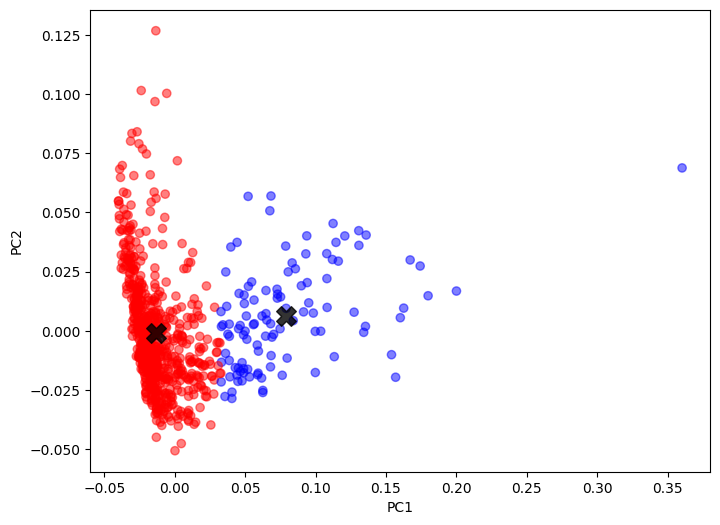

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_att_means.values)

fig, ax = plt.subplots(figsize=(8, 6))

colors = np.array(['red', 'blue'])
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans.labels_], alpha=0.5)
ax.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

### K-Medóide

In [25]:
kmedoids = KMedoids(n_clusters=2)
kmedoids.fit(data_att_medoids)

KMedoids(n_clusters=2)

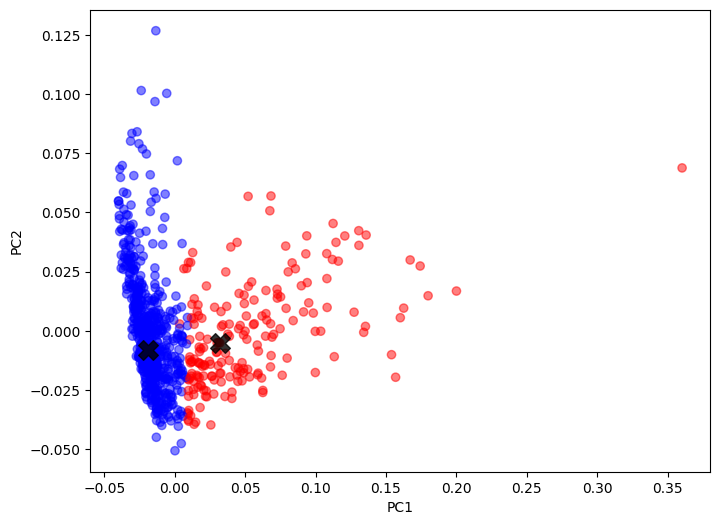

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_att_medoids.values)

fig, ax = plt.subplots(figsize=(8, 6))

colors = np.array(['red', 'blue'])
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmedoids.labels_], alpha=0.5)
ax.scatter(pca.transform(kmedoids.cluster_centers_)[:, 0], pca.transform(kmedoids.cluster_centers_)[:, 1],
           c='black', s=200, alpha=0.8, marker='X')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

### Comparação de Métricas

Para uma boa métrica, precisamos ter noção dos conceitos de distância intracluster e intercluster. A distância intracluster define o quão distante do centróide os elementos estão, já a intercluster define o quão distante os clusters estão uns dos outros. Para uma boa métrica, é necessário que ela tenha uma baixa distância intracluster e uma boa distância intercluster. Abaixo, calcularemos as distâncias intra e intercluster por meio dos métodos SSE e Centroid Linkage Distance:

In [27]:
sse = kmeans.inertia_
centroids_dist = math.dist(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1]) # Centroid Linkage Distance
print(f"Intracluster distance (SSE): {sse}")
print(f"Intercluster distance (Centroid Linkage Distance): {centroids_dist}")

Intracluster distance (SSE): 1.6889725361573904
Intercluster distance (Centroid Linkage Distance): 0.09290897195836596


In [28]:
sse = kmedoids.inertia_
centroids_dist = math.dist(kmedoids.cluster_centers_[0], kmedoids.cluster_centers_[1]) # Centroid Linkage Distance
print(f"Intracluster distance (SSE): {sse}")
print(f"Intercluster distance (Centroid Linkage Distance): {centroids_dist}")

Intracluster distance (SSE): 32.209068668281915
Intercluster distance (Centroid Linkage Distance): 0.05232962407133791


# Perguntas para o Cluster

Com os clusters formados, podemos agora nos dedicar a observar cada cluster e suas características. Vamos, através de informações gerais, determinar qual cluster tem indícios de pertencer a uma determinada classificação de "Private" e, a partir dessa escolha, determinar e visualizar o desempenho dos modelos na tarefa.

Inicialmente, retomamos os valores originais dos atributos utilizados para realizar os agrupamentos, de forma a lidarmos com valores mais facilmente relacionáveis com o que vemos na vida real e, assim, melhorando a análise. Relembremos também as características vistas anteriormente no dataset antes da distribuição.

In [29]:
data_att_private_yes.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,1974.615248,1301.930851,456.820922,29.367021,56.996454,1873.696809,434.714539,11805.980496,4585.693262,547.413121,1215.707447,71.180851,78.590426,12.943085,25.900709,10491.299645,68.911348
std,2444.239052,1367.824944,457.925752,17.846644,19.583859,2112.222348,722.792607,3709.360272,1090.612318,175.073589,632.724154,17.242372,15.406648,3.521233,12.409276,5686.403864,16.636409
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,2370.000000,250.000000,250.000000,8.000000,24.000000,2.500000,2.000000,3186.000000,15.000000
25%,618.250000,501.000000,205.500000,17.000000,42.750000,840.000000,63.000000,9100.000000,3735.750000,450.000000,800.000000,60.000000,68.000000,11.100000,16.000000,7468.750000,58.000000
50%,1132.500000,859.000000,328.000000,25.000000,55.000000,1276.500000,207.500000,11204.000000,4400.000000,500.000000,1100.000000,73.000000,81.000000,12.700000,25.000000,8957.000000,69.000000
75%,2177.000000,1579.250000,515.500000,36.250000,70.000000,2019.000000,541.000000,13994.250000,5400.000000,600.000000,1500.000000,85.000000,92.000000,14.500000,34.000000,11629.000000,81.000000
max,20192.000000,13007.000000,4615.000000,96.000000,100.000000,27378.000000,10221.000000,21700.000000,8124.000000,2340.000000,6800.000000,100.000000,100.000000,39.800000,64.000000,56233.000000,100.000000


In [30]:
data_att_private_no.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,5754.568720,3935.582938,1647.497630,22.838863,52.729858,8605.909953,1986.928910,6822.668246,3751.208531,554.161137,1681.848341,76.710900,82.791469,17.137915,14.350711,7463.260664,56.104265
std,5371.414036,3477.412482,1260.890329,16.218819,20.134973,6463.030464,2323.054725,2146.100817,859.089321,136.016115,675.401514,12.213452,12.093057,3.426130,7.535961,2700.988037,14.590229
min,233.000000,233.000000,153.000000,1.000000,12.000000,633.000000,9.000000,2580.000000,1780.000000,96.000000,400.000000,33.000000,33.000000,6.700000,0.000000,3605.000000,10.000000
25%,2211.000000,1601.000000,707.000000,12.000000,37.000000,3645.500000,610.500000,5383.500000,3128.000000,500.000000,1200.000000,71.000000,76.000000,15.100000,9.000000,5714.000000,46.000000
50%,4345.000000,2959.000000,1372.000000,19.000000,51.000000,6851.000000,1387.000000,6618.000000,3710.000000,550.000000,1651.000000,78.000000,86.000000,17.200000,13.000000,6717.000000,55.000000
75%,7752.000000,5271.000000,2254.500000,28.000000,65.000000,12536.000000,2513.500000,7844.000000,4364.000000,612.000000,2052.500000,86.000000,92.000000,19.350000,19.000000,8581.500000,65.000000
max,48094.000000,26330.000000,6392.000000,95.000000,100.000000,31643.000000,21836.000000,15732.000000,6540.000000,1125.000000,4288.000000,99.000000,100.000000,28.800000,48.000000,16527.000000,100.000000


## K-Médias

Podemos observar que os clusters no K-Médias está desbalanceado, com uma quantidade muito maior de elementos em um do que no outro. Olhando para os atributos destacados anteriormente, vemos que "F.Undergrad", "Personal" e "Outstate" são valores maiores no cluster "1" do que no "0". Logo, adotamos o cluster "1" como o cluster das universidades públicas.

In [31]:
data_att_means = data_att_no_norm
data_att_means['Cluster'] = kmeans.labels_
data_att_means.head()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
0,2885,537,7440,3300,450,2200,70,18.1,12,7041,60,0
1,2683,1227,12280,6450,750,1500,29,12.2,16,10527,56,0
2,1036,99,11250,3750,400,1165,53,12.9,30,8735,54,0
3,510,63,12960,5450,450,875,92,7.7,37,19016,59,0
4,249,869,7560,4120,800,1500,76,11.9,2,10922,15,0


In [32]:
data_att_means_0 = data_att_means[data_att_means['Cluster'] == 0]
data_att_means_1 = data_att_means[data_att_means['Cluster'] == 1]

In [33]:
data_att_means_0.describe()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.0
mean,2117.183459,443.598496,10894.508271,4411.306767,544.255639,1246.249624,71.156391,13.668271,24.193985,9814.566917,67.031579,0.0
std,1875.817720,494.976885,4018.860847,1105.929734,170.594401,623.690153,16.643848,3.799976,12.468513,5458.809924,16.985569,0.0
min,139.000000,1.000000,2580.000000,1780.000000,110.000000,250.000000,8.000000,2.500000,0.000000,3186.000000,15.000000,0.0
25%,925.000000,78.000000,7850.000000,3620.000000,450.000000,800.000000,61.000000,11.300000,14.000000,6871.000000,55.000000,0.0
50%,1419.000000,266.000000,10520.000000,4270.000000,500.000000,1125.000000,73.000000,13.200000,23.000000,8444.000000,67.000000,0.0
75%,2675.000000,639.000000,13380.000000,5150.000000,600.000000,1500.000000,84.000000,15.600000,32.000000,10891.000000,79.000000,0.0
max,11278.000000,3144.000000,21700.000000,8124.000000,2340.000000,6800.000000,100.000000,39.800000,64.000000,56233.000000,100.000000,0.0


In [34]:
data_att_means_1.describe()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.0
mean,13315.318182,3358.436364,7757.345455,4039.245455,579.445455,1925.209091,81.936364,16.605455,14.063636,8774.127273,55.709091,1.0
std,6111.164468,2764.049577,2831.048535,987.894984,125.162030,695.672074,8.826854,4.001647,7.537402,3394.839446,14.219992,0.0
min,690.000000,604.000000,2340.000000,2325.000000,96.000000,600.000000,48.000000,6.200000,2.000000,3605.000000,10.000000,1.0
25%,9413.250000,1663.250000,5934.250000,3346.000000,500.000000,1434.500000,77.000000,13.825000,9.000000,6358.000000,46.000000,1.0
50%,12753.500000,2661.000000,7314.000000,3962.000000,597.500000,1917.000000,83.500000,16.950000,13.000000,7898.500000,56.000000,1.0
75%,16133.750000,4041.250000,8894.250000,4531.000000,650.000000,2296.500000,88.000000,19.450000,17.750000,10199.750000,66.000000,1.0
max,31643.000000,21836.000000,18420.000000,7425.000000,860.000000,4288.000000,96.000000,25.300000,48.000000,21227.000000,87.000000,1.0


## K-Medóides

Desta vez os agrupamentos ficaram melhor distribuídos, embora não tanto. Olhando para os mesmos atributos que vimos anteriormente, vemos as mesmas tendências observadas no K-Médias porém com menos extremos, principalmente devido a distribuição mais similar de elementos entre os clusters. Baseado nisso, adotamos o valor "0" para universidades públicas.

In [35]:
data_att_medoids = data_att_no_norm
data_att_medoids['Cluster'] = kmedoids.labels_
data_att_medoids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 776
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   F.Undergrad  775 non-null    int64  
 1   P.Undergrad  775 non-null    int64  
 2   Outstate     775 non-null    int64  
 3   Room.Board   775 non-null    int64  
 4   Books        775 non-null    int64  
 5   Personal     775 non-null    int64  
 6   PhD          775 non-null    int64  
 7   S.F.Ratio    775 non-null    float64
 8   perc.alumni  775 non-null    int64  
 9   Expend       775 non-null    int64  
 10  Grad.Rate    775 non-null    int64  
 11  Cluster      775 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 78.7 KB


In [36]:
data_att_medoids_0 = data_att_medoids[data_att_medoids['Cluster'] == 0]
data_att_medoids_1 = data_att_medoids[data_att_medoids['Cluster'] == 1]

In [37]:
data_att_medoids_0.describe()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.0
mean,9956.947644,2459.099476,7746.481675,4051.235602,575.235602,1763.240838,78.701571,16.829319,14.136126,8279.921466,57.612565,0.0
std,6263.177240,2373.296878,3008.931777,1081.258439,173.707473,781.403524,11.097176,4.055195,7.572965,3329.947717,15.120451,0.0
min,690.000000,71.000000,2340.000000,1780.000000,96.000000,300.000000,37.000000,4.600000,0.000000,3186.000000,10.000000,0.0
25%,5273.500000,1206.500000,5782.000000,3298.000000,500.000000,1210.000000,73.000000,14.400000,9.000000,5967.500000,47.000000,0.0
50%,8528.000000,1674.000000,7090.000000,3933.000000,570.000000,1700.000000,81.000000,17.200000,14.000000,7503.000000,56.000000,0.0
75%,13465.000000,3107.000000,8881.500000,4704.500000,645.000000,2158.000000,87.000000,19.450000,18.000000,10020.500000,67.000000,0.0
max,31643.000000,21836.000000,18420.000000,7425.000000,2000.000000,6800.000000,97.000000,28.800000,48.000000,21227.000000,100.000000,0.0


In [38]:
data_att_medoids_1.describe()

,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.0
mean,1662.388699,333.446918,11333.181507,4458.989726,540.751712,1205.051370,70.719178,13.187671,25.575342,10120.506849,67.979452,1.0
std,1233.984981,363.120071,3919.261596,1084.354562,161.702918,576.401206,17.117891,3.493334,12.381631,5640.798888,16.914869,0.0
min,139.000000,1.000000,2580.000000,1880.000000,225.000000,250.000000,8.000000,2.500000,2.000000,3365.000000,15.000000,1.0
25%,860.000000,65.250000,8594.500000,3670.000000,450.000000,800.000000,60.000000,11.200000,16.000000,7076.750000,56.750000,1.0
50%,1287.500000,208.000000,10924.000000,4324.000000,500.000000,1100.000000,73.000000,12.900000,25.000000,8667.500000,68.000000,1.0
75%,1995.500000,474.250000,13762.500000,5222.500000,600.000000,1500.000000,84.000000,14.925000,34.000000,10993.750000,80.000000,1.0
max,9205.000000,1983.000000,21700.000000,8124.000000,2340.000000,4913.000000,100.000000,39.800000,64.000000,56233.000000,100.000000,1.0


# Avaliando previsão 

In [39]:
data_att_private_means = data_att_private
data_att_private_medoids = data_att_private

In [40]:
# Create converter from "Private" to "Cluster"
def converter_means(cluster):
    if cluster=='Yes':
        return 0
    else:
        return 1

def converter_medoids(cluster):
    if cluster == 'Yes':
        return 1
    else:
        return 0

## K-Médias

In [41]:
data_att_private_means['Cluster'] = data_att_private_means['Private'].apply(converter_means)
data_att_private_means.head()

,Private,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
0,Yes,2885,537,7440,3300,450,2200,70,18.1,12,7041,60,0
1,Yes,2683,1227,12280,6450,750,1500,29,12.2,16,10527,56,0
2,Yes,1036,99,11250,3750,400,1165,53,12.9,30,8735,54,0
3,Yes,510,63,12960,5450,450,875,92,7.7,37,19016,59,0
4,Yes,249,869,7560,4120,800,1500,76,11.9,2,10922,15,0


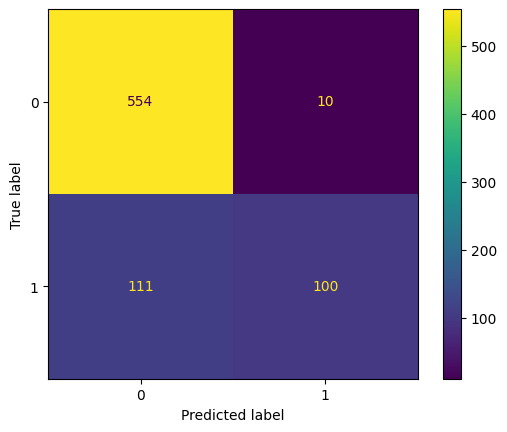

In [42]:
cm = sklearn_metrics.confusion_matrix(data_att_private_means['Cluster'],kmeans.labels_)
disp = sklearn_metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [43]:
print(sklearn_metrics.classification_report(data_att_private_means['Cluster'],kmeans.labels_))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       564
           1       0.91      0.47      0.62       211

    accuracy                           0.84       775
   macro avg       0.87      0.73      0.76       775
weighted avg       0.85      0.84      0.83       775



## K-Medóides

In [44]:
data_att_private_medoids['Cluster'] = data_att_private_medoids['Private'].apply(converter_medoids)
data_att_private_medoids.head()

,Private,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
0,Yes,2885,537,7440,3300,450,2200,70,18.1,12,7041,60,1
1,Yes,2683,1227,12280,6450,750,1500,29,12.2,16,10527,56,1
2,Yes,1036,99,11250,3750,400,1165,53,12.9,30,8735,54,1
3,Yes,510,63,12960,5450,450,875,92,7.7,37,19016,59,1
4,Yes,249,869,7560,4120,800,1500,76,11.9,2,10922,15,1


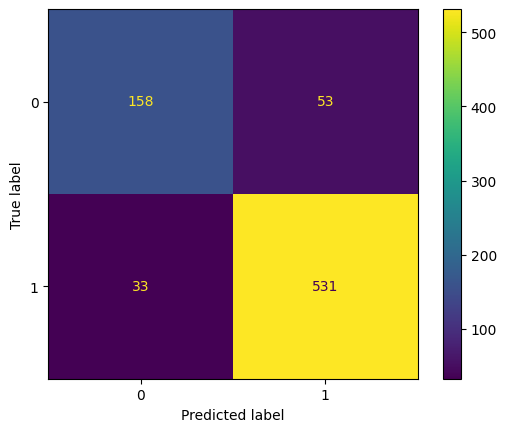

In [45]:
cm = sklearn_metrics.confusion_matrix(data_att_private_medoids['Cluster'],kmedoids.labels_)
disp = sklearn_metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [46]:
print(sklearn_metrics.classification_report(data_att_private_medoids['Cluster'],kmedoids.labels_))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       211
           1       0.91      0.94      0.93       564

    accuracy                           0.89       775
   macro avg       0.87      0.85      0.86       775
weighted avg       0.89      0.89      0.89       775

